In [5]:
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 500)
from collections import defaultdict

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

from torch.nn import init
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

device(type='cuda', index=0)

C:\Users\kevin\Anaconda3\envs\tensorflow_env\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
from market import *
from market_ml import *

In [27]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        self.dfcats = df[cats]
        self.dfconts = df.drop(cats, axis=1)
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64)
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        self.y = y.values.astype(np.float32)
        
    def __len__(self): return len(self.y)
 
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    
def apply_dl(X, y, categorical):
    ds = RegressionColumnarDataset(X, categorical, y)
    params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 0}
    return data.DataLoader(ds, **params)

In [7]:
financial_data = pd.read_csv("csv_files/company_stats_2019-08-30.csv")
financial_data = financial_data[pd.notnull(financial_data['Industry'])] # Remove rows with nan values for industry
financial_data = financial_data[pd.notnull(financial_data['Sector'])]  # Remove rows with nan values for sector
# Convert sector and industry to categoricals
financial_data['Industry'] = financial_data['Industry'].astype('category')
financial_data['Sector'] = financial_data['Sector'].astype('category')

to_remove = ['Ticker', 'Name', 'Price', 'IPO Year']
categorical = ['Sector', 'Industry']
# Convert categorical variables to integers to feed in the model
financial_data[categorical] = financial_data[categorical].apply(lambda x: x.cat.codes)
feature_cols = [x for x in financial_data.columns if x not in to_remove]
financial_data = financial_data.fillna(0)
X = financial_data[feature_cols]
Y = financial_data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
    
# Covert to dataloaders
traindl = apply_dl(X_train, y_train, categorical)
valdl = apply_dl(X_test, y_test, categorical)

In [8]:
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)
    
def inv_y(y): 
    return np.exp(y)
    
def rmse(targ, y_pred):
    #print(inv_y(y_pred), inv_y(targ))
    #return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    return np.sqrt(mean_squared_error(y_pred, targ))


class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn=True):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, "cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x.squeeze()

In [9]:
y_range = (0, y_train.max()*1.2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using: " + str(device))
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')




cat_sz = [(c, financial_data[c].max()+1) for c in categorical]


emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]


m = MixedInputModel(emb_szs=emb_szs,
    n_cont=len(financial_data.columns)-len(categorical) - 4, 
                    emb_drop=0.04,
                    out_sz=1, 
                    szs=[1000,500,250], 
                    drops=[0.001,0.01,0.01], 
                    y_range=y_range).to(device)

Using: cuda:0


In [10]:
def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description('Epoch {epoch}')
            
            opt.zero_grad()
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            loss.backward()
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            scheduler.step()
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [11]:
opt = optim.Adam(m.parameters(), 1e-2)
lr_cosine = lr_scheduler.CosineAnnealingLR(opt, 1000)
 
lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)
 
lr, tloss, vloss = fit(model=m, train_dl=traindl, val_dl=valdl, loss_fn=F.mse_loss, opt=opt, scheduler=lr_cosine, epochs=50)

Epoch 0: train_loss: 131355.1686 train_rmse: 365.4733 | val_loss: 61413.8281 val_rmse: 247.9668


Epoch 1: train_loss: 43494.6437 train_rmse: 208.3231 | val_loss: 23567.2422 val_rmse: 153.5334


Epoch 2: train_loss: 24631.8940 train_rmse: 157.6175 | val_loss: 17626.1209 val_rmse: 132.8305


Epoch 3: train_loss: 17909.9381 train_rmse: 134.6848 | val_loss: 16922.0172 val_rmse: 130.2776


Epoch 4: train_loss: 14767.0015 train_rmse: 121.8652 | val_loss: 10929.9983 val_rmse: 104.7778


Epoch 5: train_loss: 10540.0004 train_rmse: 102.5824 | val_loss: 8510.1360 val_rmse: 92.2311


Epoch 6: train_loss: 6927.4228 train_rmse: 83.7133 | val_loss: 4100.7456 val_rmse: 64.0279


Epoch 7: train_loss: 5885.5689 train_rmse: 77.0693 | val_loss: 3672.6568 val_rmse: 60.6294


Epoch 8: train_loss: 3552.6568 train_rmse: 60.2640 | val_loss: 3382.8597 val_rmse: 58.2120


Epoch 9: train_loss: 3503.9423 train_rmse: 59.4501 | val_loss: 3937.4081 val_rmse: 62.8174


Epoch 10: train_loss: 3449.1198 train_rmse: 59.3964 | val_loss: 3628.1486 val_rmse: 60.3003


Epoch 11: train_loss: 3019.4325 train_rmse: 54.9207 | val_loss: 3509.0785 val_rmse: 59.2846


Epoch 12: train_loss: 2903.7307 train_rmse: 54.3066 | val_loss: 4156.1115 val_rmse: 64.5306


Epoch 13: train_loss: 3689.6042 train_rmse: 61.1785 | val_loss: 4081.1232 val_rmse: 63.9387


Epoch 14: train_loss: 3413.5986 train_rmse: 58.3938 | val_loss: 3529.6558 val_rmse: 59.4036


Epoch 15: train_loss: 3303.1489 train_rmse: 56.3151 | val_loss: 3467.0324 val_rmse: 58.9216


Epoch 16: train_loss: 2764.9085 train_rmse: 53.0992 | val_loss: 3312.1710 val_rmse: 57.4871


Epoch 17: train_loss: 2468.6620 train_rmse: 49.3429 | val_loss: 2858.7391 val_rmse: 53.4852


Epoch 18: train_loss: 1838.6488 train_rmse: 42.8263 | val_loss: 2875.3490 val_rmse: 53.6686


Epoch 19: train_loss: 1858.2113 train_rmse: 43.1257 | val_loss: 3178.5464 val_rmse: 56.2612


Epoch 20: train_loss: 1901.6481 train_rmse: 42.7412 | val_loss: 2720.5040 val_rmse: 52.0973


Epoch 21: train_loss: 1686.6812 train_rmse: 41.1553 | val_loss: 2760.8812 val_rmse: 52.5256


Epoch 22: train_loss: 1554.2395 train_rmse: 39.7411 | val_loss: 2570.9843 val_rmse: 50.7758


Epoch 23: train_loss: 1545.6413 train_rmse: 39.4968 | val_loss: 2251.3610 val_rmse: 47.5148


Epoch 24: train_loss: 1651.3105 train_rmse: 40.8437 | val_loss: 3397.5764 val_rmse: 58.2740


Epoch 25: train_loss: 2205.7327 train_rmse: 46.5182 | val_loss: 2230.3719 val_rmse: 47.2430


Epoch 26: train_loss: 1407.9913 train_rmse: 37.7593 | val_loss: 2671.4422 val_rmse: 51.5177


Epoch 27: train_loss: 1206.5622 train_rmse: 34.9425 | val_loss: 2563.0529 val_rmse: 50.6912


Epoch 28: train_loss: 1584.3690 train_rmse: 40.3572 | val_loss: 2521.3910 val_rmse: 50.3308


Epoch 29: train_loss: 1505.2998 train_rmse: 36.9045 | val_loss: 1902.6239 val_rmse: 43.7163


Epoch 30: train_loss: 1247.6023 train_rmse: 35.4183 | val_loss: 1876.6244 val_rmse: 43.3361


Epoch 31: train_loss: 1333.5976 train_rmse: 34.7365 | val_loss: 1665.6409 val_rmse: 40.8421


Epoch 32: train_loss: 1046.5469 train_rmse: 32.8631 | val_loss: 1832.8511 val_rmse: 42.7100


Epoch 33: train_loss: 1057.1658 train_rmse: 32.4451 | val_loss: 1737.0933 val_rmse: 41.7178


Epoch 34: train_loss: 1034.7979 train_rmse: 32.2195 | val_loss: 1558.0639 val_rmse: 39.5305


Epoch 35: train_loss: 1089.7390 train_rmse: 32.1504 | val_loss: 2133.1332 val_rmse: 46.1695


Epoch 36: train_loss: 1053.5097 train_rmse: 32.6377 | val_loss: 1643.0433 val_rmse: 40.5467


Epoch 37: train_loss: 1037.4712 train_rmse: 32.5392 | val_loss: 1986.3333 val_rmse: 44.5801


Epoch 38: train_loss: 890.2808 train_rmse: 30.1268 | val_loss: 1783.3252 val_rmse: 42.3024


Epoch 39: train_loss: 910.2848 train_rmse: 30.5869 | val_loss: 1840.9559 val_rmse: 42.9009


Epoch 40: train_loss: 991.0352 train_rmse: 31.6537 | val_loss: 1568.2108 val_rmse: 39.6337


Epoch 41: train_loss: 1165.0741 train_rmse: 33.3017 | val_loss: 2015.7633 val_rmse: 45.0237


Epoch 42: train_loss: 863.1789 train_rmse: 28.1612 | val_loss: 1710.9613 val_rmse: 41.2425


Epoch 43: train_loss: 817.9965 train_rmse: 28.5455 | val_loss: 1640.5530 val_rmse: 40.4800


Epoch 44: train_loss: 921.7027 train_rmse: 30.2499 | val_loss: 1971.1184 val_rmse: 44.4769


Epoch 45: train_loss: 834.5655 train_rmse: 28.1870 | val_loss: 1410.6584 val_rmse: 37.4047


Epoch 46: train_loss: 945.2971 train_rmse: 31.0672 | val_loss: 1698.3390 val_rmse: 41.2058


Epoch 47: train_loss: 725.3129 train_rmse: 27.0891 | val_loss: 1763.3513 val_rmse: 41.9058


Epoch 48: train_loss: 916.7649 train_rmse: 30.1299 | val_loss: 1353.5349 val_rmse: 36.8525


Epoch 49: train_loss: 816.0411 train_rmse: 28.7334 | val_loss: 1310.2541 val_rmse: 36.1745



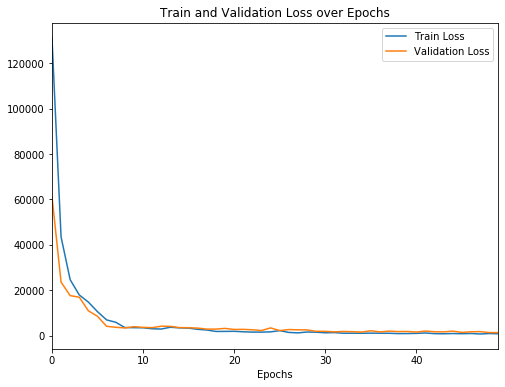

In [12]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]
p = pd.DataFrame({'Train Loss': t, 'Validation Loss': v, 'Epochs': range(50)})

_ = p.plot(x='Epochs', y=['Train Loss', 'Validation Loss'], 
           title='Train and Validation Loss over Epochs')

In [26]:
l = [x for x in feature_cols if x not in ['Industry', 'Sector']]
#m.eval()

X = financial_data[feature_cols]
Y = financial_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
    
# Covert to dataloaders
traindl = apply_dl(X_train, y_train, categorical)
valdl = apply_dl(X_test, y_test, categorical)

one, two, three,  four,  five = valdl

y_pred = m(one[0].cuda(), one[1].cuda())